Sparse Identification of Nonlinear Dynamics (SINDy) is a data driven methods of discovering governing equation from a dynamical time series data. It was introduced by Brunton et al. in 2016 to identify sparse and interpretable models from the data. We assume that the data dynamics are expressed as linear combination of a library of candidate functions and use sparse regression to select only relevant terms.  

$${\dot{\textbf{x}}} = \mathbf{\Theta}(\textbf{x}) \mathbf{\xi}$$
where $\mathbf{\Theta}(\mathbf{x})$ is a matrix of candidate functions evaluated on the state $\mathbf{x}$, and $\boldsymbol{\xi}$ is a sparse coefficient vector found via optimization.

## Step 1: Generate Synthetic Data from Simple Linear and Non-linear ODE
We simulate the simple linear and non-linear 1D ODE within time domain $t=[0, 1]$ with 1000 time steps ($\Delta t = 0.001$).

For linear ODE we use:
$$dx/dt = 1.0 x$$

For non-linear ODE we use:
$$dx/dt = 1.0 k(t) x$$

where

$$k = 1+1/(1 +  e^{A(t-t_0)})$$

$A$ and $t_0$ can vary

Initial condition is $u(0) = 3$

Research task is to reconstruct $k$ function with $A$ and $t_0$ from SINDY

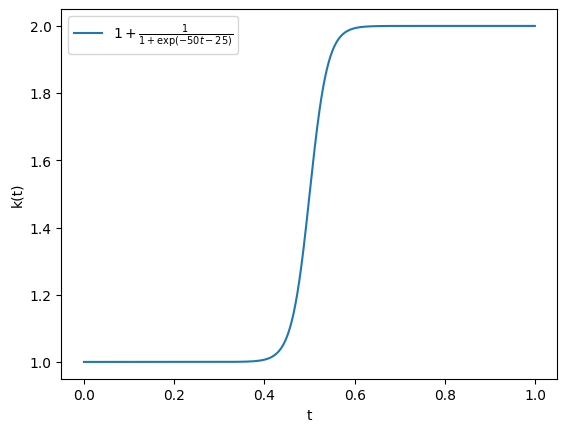

In [13]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

odeint = sp.integrate.odeint
solve_ivp = sp.integrate.solve_ivp

# Integrator keywords for solve_ivp
integrator_keywords = {
    'rtol':1e-12,
    'method':'LSODA',
    'atol':1e-12
}
dt = 1e-3
t = np.arange(0,1,dt)

def k(t):
    return 1.0+1.0/(1.0+np.exp(-50*(t-0.5)))
plt.plot(t,k(t),label=r"$1+\frac{1}{1+\exp(-50t-25)}$")
plt.xlabel("t")
plt.ylabel("k(t)")
plt.legend()
plt.show()

# Resolution using ```scipy.integrate.solve_ivp```

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-03 ...  9.980e-01  9.990e-01]
        y: [[ 3.000e+00  3.003e+00 ...  1.339e+01  1.342e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 461
     njev: 0
      nlu: 0


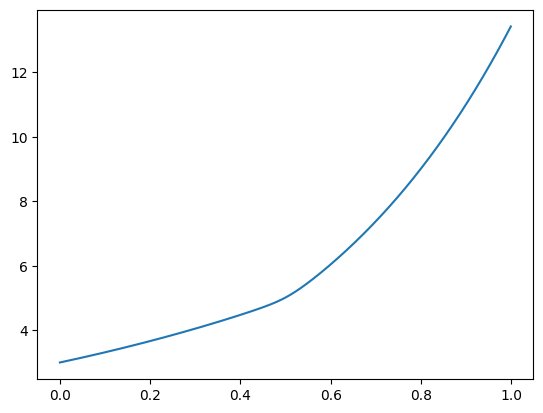

In [14]:
def non_linear_ode(time,x):
    return 1.0*k(time)*x
t_span = (t[0],t[-1])
x0 = 3.0
num_solution = solve_ivp(non_linear_ode, t_span, [x0], t_eval=t,**integrator_keywords)

print(num_solution)
plt.plot(num_solution.t,num_solution.y[0])
plt.show()

# Resolution using forward euler

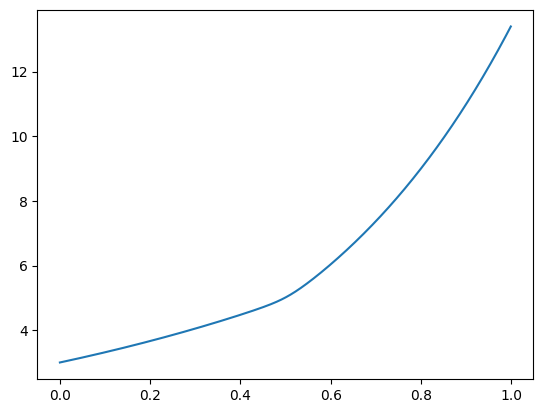

In [15]:
x_fe = np.zeros_like(t)
x_fe[0] = x0
for i in range(1,len(x_fe)):
    x_fe[i] = (1+dt*k(t[i-1]))*x_fe[i-1]
plt.plot(t,x_fe)
plt.show()

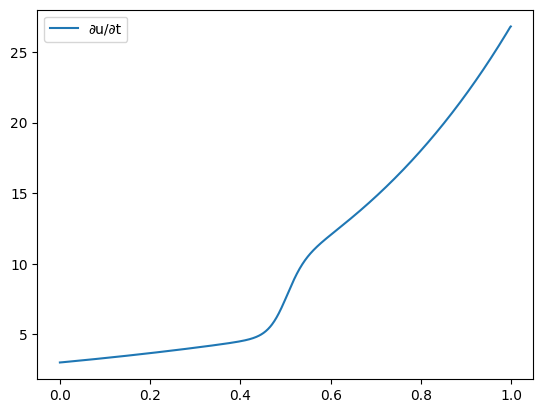

In [16]:
u_t = np.gradient(num_solution.y[0],dt,axis=0) # ∂u/∂t
plt.plot(t,u_t,label="∂u/∂t")
plt.legend()
plt.show()

In [ ]:
# Build library
# =============
# Candidate term : [1,x, x**2, x**3]
x = num_solution.y[0]
x2 = x*x
x3 = x2*x
Theta_list = np.array([
    np.ones_like(x),
    x,
    x2,
    x3
])
print(f"Theta_list: {Theta_list.shape}")
# Skip boundaries for derivatives (more stable), interior points
it = slice(1,-1)
xt_int = u_t[it]

terms_int = [term[it] for term in Theta_list]
terms_int = np.array(terms_int)
nt_int = len(xt_int)
num_terms = len(Theta_list)

# Coefficient over time , reconstruct k(t)
xi_matrix = np.zeros((num_terms,nt_int))
def stlsq_per_time(Theta_t, Ut_col, threshold=0.05, max_iter=100):
    """Sparse regression for a single time step"""
    xi = sp.linalg.lstsq(Theta_t, Ut_col)[0]
    for _ in range(max_iter):
        small = np.abs(xi) < threshold
        xi[small] = 0
        big = ~small
        if np.any(big):
            xi[big] = sp.linalg.lstsq(Theta_t[:, big], Ut_col)[0]
        else:
            break
    return xi
feature_names = ['1', 'x', 'x^2', 'x^3']

# xi tensor (functions x nt); 0 where not computed
xi_over_t = np.zeros((len(feature_names), nt_int))
# Solve for coefficients at each time steps
for j in range(nt_int):
    xj = xt_int[j]
    x2j = xj**2
    x3j = xj*x2j
    ones = np.ones_like(xj)
    Theta_j = np.c_[ones, xj, x2j, x3j]
    xt_j = xt_int[j]
    if np.linalg.norm(xt_j)>1e-8: # skipping low-signal times
        xi_j = stlsq_per_time(np.array(Theta_j), np.array([xt_j]))
        xi_over_t[:,j] = xi_j


Theta_list: (4, 1000)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.11088907 0.11066752 0.1104464  ... 0.         0.         0.        ]]


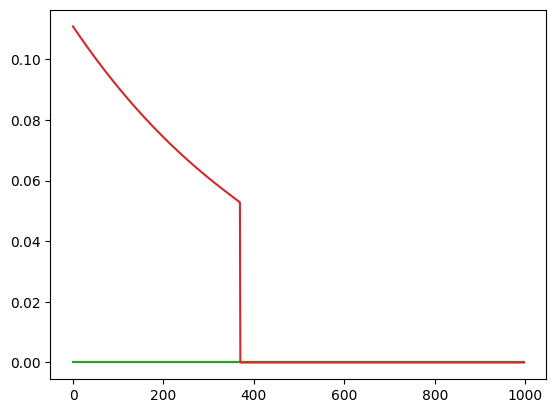

In [ ]:
print(xi_over_t)
for i in range(len(xi_over_t)):
    plt.plot(xi_over_t[i])

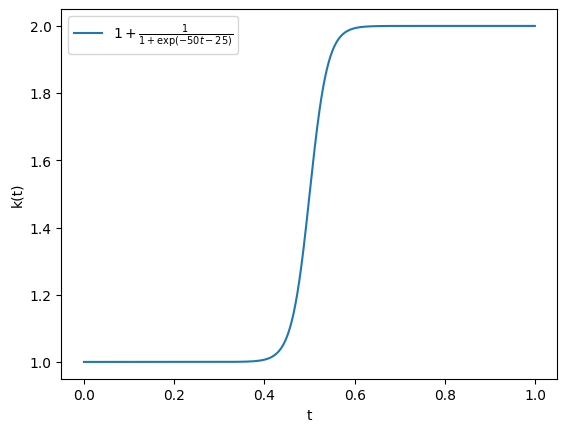

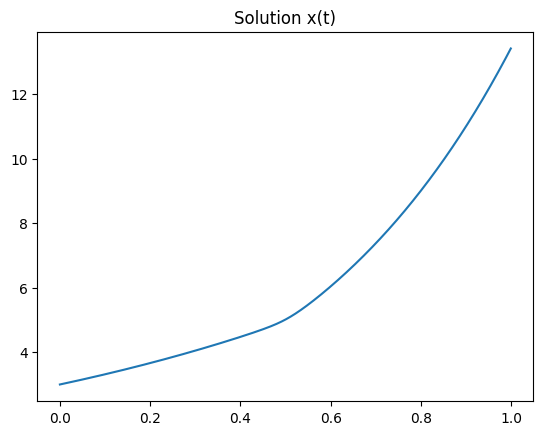

Theta_list shape: (4, 1000)
Theta_int shape: (998, 4)
xt_int shape: (998,)


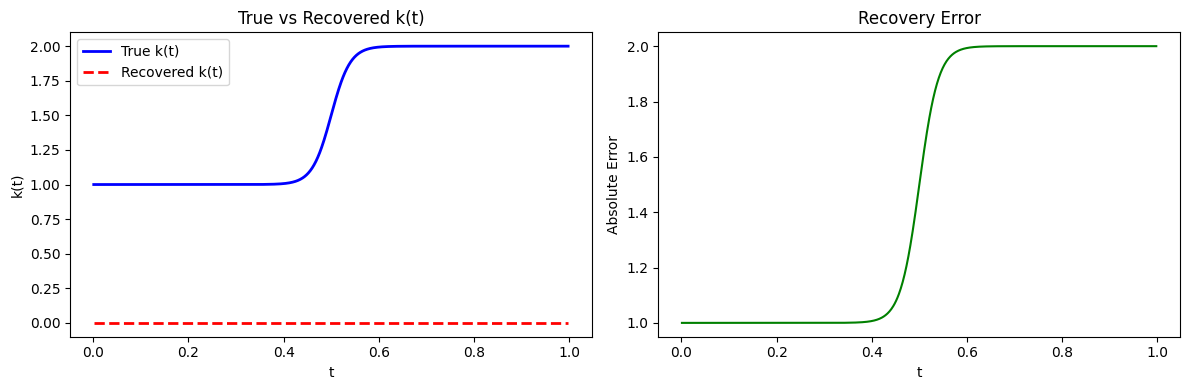

Average error: 1.499499


In [ ]:
# Build library
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

odeint = sp.integrate.odeint
solve_ivp = sp.integrate.solve_ivp

# Integrator keywords for solve_ivp
integrator_keywords = {
    'rtol':1e-12,
    'method':'LSODA',
    'atol':1e-12
}
dt = 1e-3
t = np.arange(0,1,dt)

def k(t):
    return 1.0+1.0/(1.0+np.exp(-50*(t-0.5)))

plt.plot(t,k(t),label=r"$1+\frac{1}{1+\exp(-50t-25)}$")
plt.xlabel("t")
plt.ylabel("k(t)")
plt.legend()
plt.show()

def non_linear_ode(time,x):
    return 1.0*k(time)*x

t_span = (t[0],t[-1])
x0 = 3.0
num_solution = solve_ivp(non_linear_ode, t_span, [x0], t_eval=t,**integrator_keywords)

plt.plot(num_solution.t,num_solution.y[0])
plt.title("Solution x(t)")
plt.show()

# ============= FIXED PART =============
x = num_solution.y[0]

# Compute the derivative dx/dt using finite differences
# This is our u_t that was missing
u_t = np.gradient(x, t)  # dx/dt

# Candidate term : [1, x, x**2, x**3]
x2 = x*x
x3 = x2*x

Theta_list = np.array([
    np.ones_like(x),
    x,
    x2,
    x3
])
print(f"Theta_list shape: {Theta_list.shape}")

# Skip boundaries for derivatives (more stable), interior points
it = slice(1,-1)
xt_int = u_t[it]  # This was undefined before!

# Build the library matrix for interior points
# Each column represents a candidate function evaluated at all time points
Theta_int = Theta_list[:, it].T  # Shape: (n_points, n_terms)
print(f"Theta_int shape: {Theta_int.shape}")
print(f"xt_int shape: {xt_int.shape}")

num_terms = len(Theta_list)
nt_int = len(xt_int)

# Coefficient over time, reconstruct k(t)
xi_matrix = np.zeros((num_terms, nt_int))

def stlsq_per_time(Theta_t, Ut_col, threshold=0.05, max_iter=100):
    """Sparse regression for a single time step"""
    # FIX: Ensure inputs are 2D arrays for lstsq
    Theta_t = Theta_t.reshape(-1, 1) if Theta_t.ndim == 1 else Theta_t
    Ut_col = np.array([Ut_col]) if np.isscalar(Ut_col) else Ut_col.reshape(-1, 1)

    xi = sp.linalg.lstsq(Theta_t, Ut_col)[0].flatten()

    for _ in range(max_iter):
        small = np.abs(xi) < threshold
        xi[small] = 0
        big = ~small
        if np.any(big):
            xi[big] = sp.linalg.lstsq(Theta_t[:, big], Ut_col)[0].flatten()
        else:
            break
    return xi

feature_names = ['1', 'x', 'x^2', 'x^3']

# xi tensor (functions x nt); 0 where not computed
xi_over_t = np.zeros((len(feature_names), nt_int))

# Solve for coefficients at each time step
for j in range(nt_int):
    # For each time point, we have one equation: dx/dt = coefficients * library_terms
    Theta_j = Theta_int[j:j+1, :]  # Single time point, all terms
    xt_j = xt_int[j]

    if np.abs(xt_j) > 1e-8:  # skipping low-signal times
        xi_j = stlsq_per_time(Theta_j, xt_j)
        xi_over_t[:, j] = xi_j

# The recovered k(t) should be the coefficient of the 'x' term
recovered_k = xi_over_t[1, :]  # index 1 corresponds to 'x'

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(t[it], k(t[it]), 'b-', label='True k(t)', linewidth=2)
plt.plot(t[it], recovered_k, 'r--', label='Recovered k(t)', linewidth=2)
plt.xlabel('t')
plt.ylabel('k(t)')
plt.legend()
plt.title('True vs Recovered k(t)')

plt.subplot(1, 2, 2)
plt.plot(t[it], np.abs(k(t[it]) - recovered_k), 'g-')
plt.xlabel('t')
plt.ylabel('Absolute Error')
plt.title('Recovery Error')

plt.tight_layout()
plt.show()

print(f"Average error: {np.mean(np.abs(k(t[it]) - recovered_k)):.6f}")

In [ ]:
print(recovered_k)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Scipy optimization approach

In [1]:
import scipy as sp
import numpy as np


## Example of minimization of function and approximation methods
1. $f(x)=x^2+2x$
2. Approximate $\exp(x)\approx a+bx+cx^2$

In [4]:
def poly_objective(x):
    return x[0]**2+2*x[0]

# Initial guess, near and far from the optimum value
x0 = [0,1000]

# Minimize using BFGS methods
results_near = sp.optimize.minimize(poly_objective, x0[0], method="BFGS")
print(f"results_near: \n{results_near}")

results_far = sp.optimize.minimize(poly_objective,x0[1],method="BFGS")
print(f"\nresults_far: \n{results_far}")

print(f"Minimum at: far={results_far.x}, near={results_near.x}")

results_near: 
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.0
        x: [-1.000e+00]
      nit: 2
      jac: [ 0.000e+00]
 hess_inv: [[ 5.000e-01]]
     nfev: 6
     njev: 3

results_far: 
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.0
        x: [-1.000e+00]
      nit: 3
      jac: [ 0.000e+00]
 hess_inv: [[ 5.000e-01]]
     nfev: 16
     njev: 8
Minimum at: far=[-1.00000001], near=[-1.00000001]


  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.0007658531578937063
        x: [ 9.961e-01  1.106e+00  5.375e-01]
      nit: 5
      jac: [-1.116e-07 -3.170e-07  6.762e-08]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
Optimal coefficients: a=0.9961, b=1.1058, c=0.5375
Final MSE: 0.000766


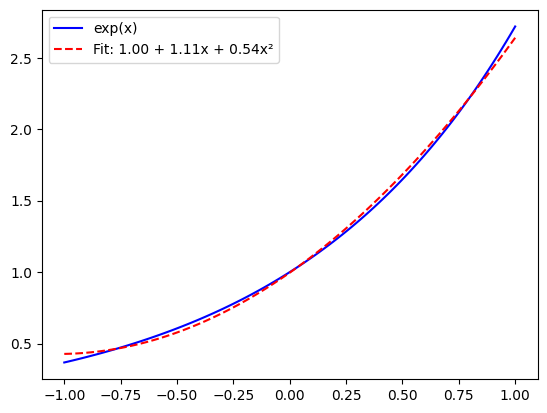

In [12]:
import matplotlib.pyplot as plt

x_data = np.linspace(-1,1,100)
y_true = np.exp(x_data)

def objective(params,y_true=y_true,x_data=x_data):
    a,b,c = params
    y_pred = a+b*x_data+c*x_data**2
    return np.sum((y_true-y_pred)**2)/len(y_pred)

x0 = [1,1,1]
results = sp.optimize.minimize(objective, x0,method="L-BFGS-B")
a_opt, b_opt, c_opt = results.x
print(results)
print(f"Optimal coefficients: a={a_opt:.4f}, b={b_opt:.4f}, c={c_opt:.4f}")
print(f"Final MSE: {results.fun:.6f}")

# Plot results
y_fit = a_opt + b_opt*x_data + c_opt*x_data**2
plt.plot(x_data, y_true, 'b-', label='exp(x)')
plt.plot(x_data, y_fit, 'r--', label=f'Fit: {a_opt:.2f} + {b_opt:.2f}x + {c_opt:.2f}x²')
plt.legend()
plt.show()

# Approximate $u_t = k(t)u$

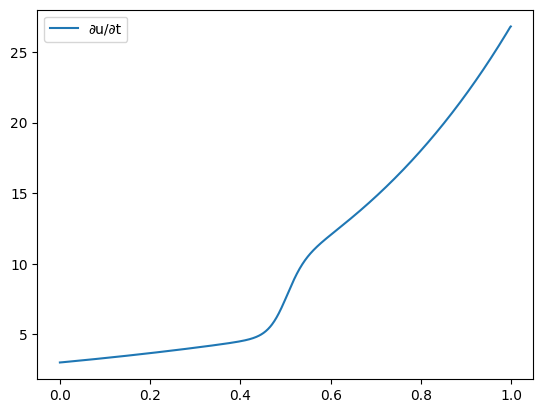

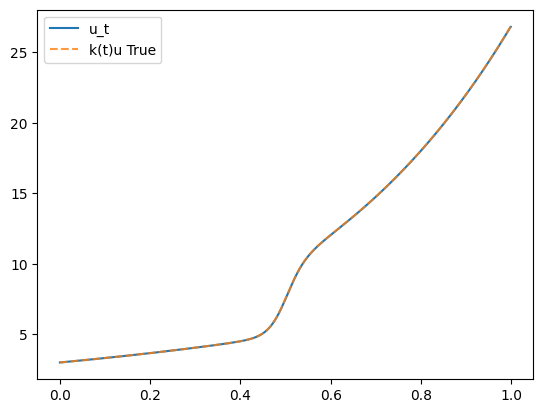

In [28]:
u = num_solution.y[0]
u_t = np.gradient(u,dt,axis=0) # ∂u/∂t
plt.plot(t,u_t,label="∂u/∂t")
plt.legend()
plt.show()
# Approximate u_t = k(t)u
plt.plot(t,u_t,label="u_t")
plt.plot(t,k(t)*u,"--",alpha=0.8,label =  "k(t)u True")
plt.legend()
plt.show()
u_t_true = k(t)*u

In [30]:
def objective(params,u_t=u_t,u=u):
    k_values = params
    ut_pred = k_values * u
    return np.sum((u_t-k_values*u)**2)/np.size(u) # MSE

k_initial = np.random.randn(u.shape[0])
results = sp.optimize.minimize(objective,k_initial,method="SLSQP",tol=1e-8)
print(results)
u_t_pred = results.x * u


     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 2.2738511194352473e-08
           x: [ 1.000e+00  9.997e-01 ...  2.000e+00  1.998e+00]
         nit: 62
         jac: [-9.870e-06 -6.069e-06 ... -9.530e-06 -8.698e-06]
        nfev: 62063
        njev: 62
 multipliers: []


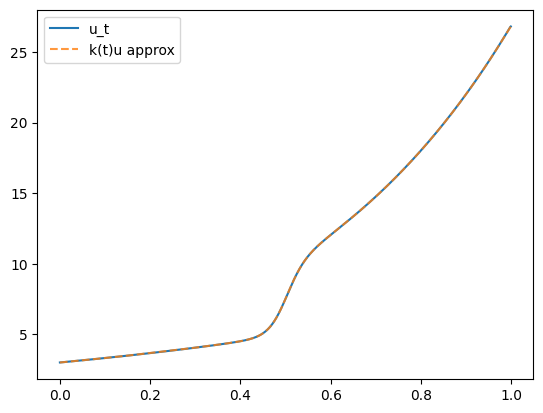

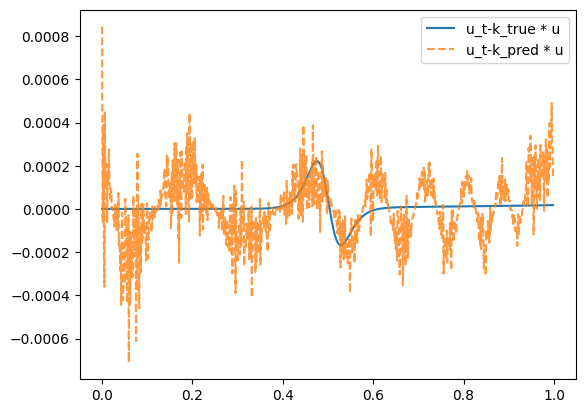

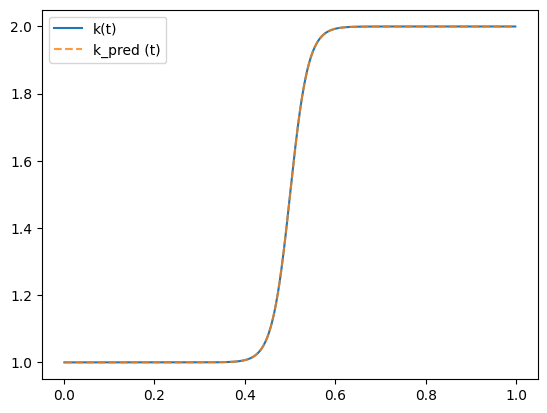

In [32]:
plt.plot(t,u_t,label="u_t")
plt.plot(t,u_t_pred,"--",alpha=0.8,label="k(t)u approx")
plt.legend()
plt.show()

plt.plot(t[1:-1],(u_t-u_t_true)[1:-1],label="u_t-k_true * u")
plt.plot(t[1:-1],(u_t-u_t_pred)[1:-1],"--",alpha=0.8,label = "u_t-k_pred * u")
plt.legend()
plt.show()

plt.plot(t[1:-1],k(t[1:-1]),label="k(t)")
plt.plot(t[1:-1],results.x[1:-1],"--",alpha=0.8,label="k_pred (t)")
plt.legend()
plt.show()
